# Bear Spring EPM (Equivalent Porous Media) Model

Model started 10/14/24. Modeled after Langevin, C. 2024, UMN Hydrocamp  
[Link to Reference Code](https://github.com/langevin-usgs/umn2024/tree/main)

## This is a copy of the actual EPM model that is designed solely to figure out how to get the watershed geoJSON file to fit onto a model grid with the appropriate Coordinate Reference System

In [1]:
# import python packages
import pathlib as pl #Pathlib used for switching between directories, accessing files
import scipy.special #Used for additional plotting of MODFLOW data
import numpy as np #for numerical operations
import matplotlib.pyplot as plt #for creating plots
from datetime import datetime #for dealing with datetime objects
import pandas as pd #for handling dataframes
import flopy #Used for interacting with MODFLOW, developing MODFLOW inputs and reading outputs
from pyproj import Proj#Used for coordinate functions and re-mapping
import rasterio #For working with raster data and shapefiles
import geopandas as gpd#for importing shapefiles
from shapely.geometry import LineString
from shapely.validation import make_valid

## Load External Data

Import the Galena Well Metadata  
Import the Sinkhole and Spring Data
Import precipitation Data  
Import Well Data  
Import DEM Data  
Import DTW in Galena Well

In [104]:
#Load the Watershed Extent data from USGS StreamStats
geoJSON = './data/WS_1.geojson'
watershed = gpd.read_file(geoJSON)

projected_crs = 'EPSG:32615'
watershed = watershed.to_crs(projected_crs)

#Check for geometry types (need to extract a polygon dataset)
watershed_types = watershed.geometry.type.unique()
print(watershed_types)

wsPolygon = watershed[watershed.geometry.type == 'Polygon']

#repair the geometry for any errors that make the polygon not valid
wsPolygon.loc[:,'geometry'] = wsPolygon['geometry'].apply(make_valid)
print(f'The polygon is Valid: {wsPolygon.is_valid}')
wsPolygon = wsPolygon.explode(index_parts=True)

#get the bounding box for the watershed polygon
bounds = wsPolygon.total_bounds
print(f'min x: {bounds[0]}, min y: {bounds[1]}, max x: {bounds[2]}, max y: {bounds[3]}')

['Point' 'Polygon']
The polygon is Valid: 1    True
dtype: bool
min x: 557184.4037729454, min y: 4867185.873280004, max x: 561054.4043688355, max y: 4870485.873787433


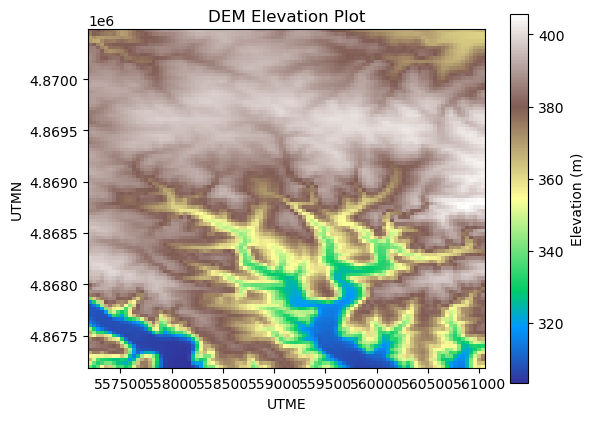

Current UTM Boundary: 557184.4037729454
Current UTM Boundary: 561054.4043688355
Current UTM Boundary: 4867185.873280004
Current UTM Boundary: 4870485.873787433


In [109]:
#Import the DEM data
with rasterio.open('./data/DEM_1m/dem_1m_m.bil') as src:
    #define the window of useful data(in UTM coords) from the larger DEM shapefile
    window = rasterio.windows.from_bounds(bounds[0], bounds[2], bounds[1], bounds[3], transform=src.transform)
    extent = rasterio.windows.bounds(window, src.transform)#get window boundaries to confirm they are correct
    
    #convert all of the data to a grid so it can be used with the MODFLOW model
    width = ncol#set the width of the grid
    height = nrow #set the height of the grid
    transform = rasterio.transform.from_bounds(*extent, width, height) #transform the data to the grid
    
    #Import the DEM and apply it to the grid
    dem_grid = src.read(
    1,
    out_shape = (height, width),
    window = window,
    resampling= rasterio.enums.Resampling.bilinear
    )
    
    #mask out the erroneous data (excessively large values due to data errors)
    maxval = 10000
    dem_grid = np.ma.masked_where(dem_grid > maxval, dem_grid)

#Plot DEM as a colorplot to evaluate all of the values and establish the value range and units
plt.imshow(dem_grid, cmap='terrain', extent=extent)
plt.colorbar(label='Elevation (m)')
plt.xlabel('UTME')
plt.ylabel('UTMN')
plt.title('DEM Elevation Plot')
plt.show()

#print the boundary values of the DEM
for i in range(len(extent)):
    print(f'Current UTM Boundary: {extent[i]}')
    


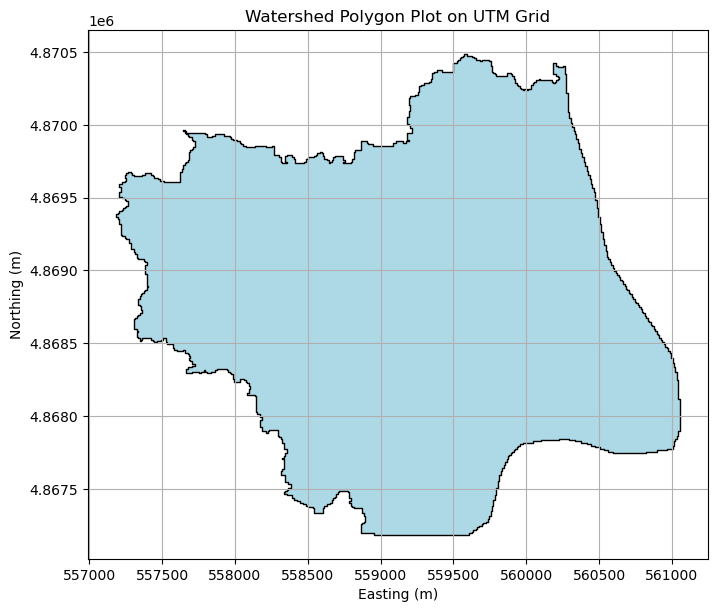

In [3]:
# Plot the polygon using the correct CRS to ensure that the bounds are in the right coordinate system and that the polygon looks correct
fig, ax = plt.subplots(figsize=(8, 8))
wsPolygon.plot(ax=ax, color='lightblue', edgecolor='black', label='Watershed Polygon')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
plt.title('Watershed Polygon Plot on UTM Grid')
plt.grid(True)

## Create the MODFLOW Model Grid

Place the grid onto real world coordinates for use with the DEM data and geological data

In [115]:
#Set all of the relevant input parameters for the grid construction
Lx = bounds[2] - bounds[0] #Use the bounding box of the model to be the length along the x axis
Ly = bounds[3] - bounds[1] #Use the bounding box of the model to be the length along the y axis
nlay = 1 #for the sake of this test, set only a singular layer. Will eventually make this more complicated
nrow = 100
ncol = 100
delr = Lx / ncol * np.ones(ncol, dtype=float)
delc = Ly / nrow * np.ones(nrow, dtype=float)
top = dem_grid #elevation of the singular layer top
botm = -50 * np.ones((nlay, nrow, ncol), dtype=float) #elevation of the singular layer bottom

In [116]:
# Generate the model grid in flopy
sg = flopy.discretization.StructuredGrid(
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=top,
    botm=botm,
    xoff=bounds[0],
    yoff=bounds[1],
    crs= 'EPSG:32615'
)

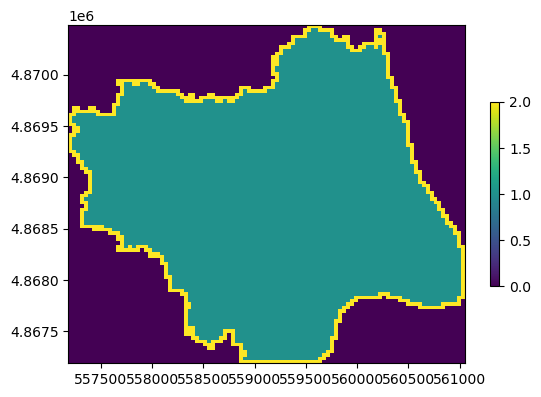

In [117]:
#create an idomain indicator array
idomain = np.zeros((nlay, nrow, ncol), dtype=int)

#create a flopy grid intersect object to use with the idomain array
gi = flopy.utils.GridIntersect(sg)

#extract the raw Polygon from the GeoDataFrame object wsPolygon
domain = wsPolygon.geometry.values[0]

#inside the domain polygon (watershed polygon)
ixp = gi.intersect(domain)
for i, j in ixp["cellids"]:
    idomain[:, i, j] = 1
    
#touching the domain polygon (idomain = 2) (boundary cells)
ls = LineString([p for p in domain.exterior.coords])
ixl = gi.intersect(ls)
for i, j in ixl["cellids"]:
    idomain[:, i, j] = 2
    
#all cells not in the domain or touching it are assigned an idomain value of 0
pmv = flopy.plot.PlotMapView(modelgrid=sg)
cb = pmv.plot_array(idomain)
plt.colorbar(cb, shrink=0.5)

In [132]:
ws = './sim-01_EPM_wsgrid'
name = 'EPM_wsgrid'
sim = flopy.mf6.MFSimulation(sim_name=name, sim_ws=ws, exe_name='mf6')
tdis = flopy.mf6.ModflowTdis(sim)
ims = flopy.mf6.ModflowIms(sim, print_option='all', inner_maximum=100)
gwf = flopy.mf6.ModflowGwf(sim, modelname=name, save_flows=True)
dis = flopy.mf6.ModflowGwfdis(
    gwf, nlay=nlay, nrow=nrow, ncol=ncol, delr=delr, delc=delc, 
    top=top, botm=botm, idomain=idomain)
ic = flopy.mf6.ModflowGwfic(gwf, strt=top)
npf = flopy.mf6.ModflowGwfnpf(gwf, save_specific_discharge=True, icelltype=1)
chdspd = [[(0, i, j), 100.] for i, j in ixl["cellids"]]
chd = flopy.mf6.ModflowGwfchd(gwf, stress_period_data=chdspd)
rch = flopy.mf6.ModflowGwfrcha(gwf, recharge=0.001)
oc = flopy.mf6.ModflowGwfoc(gwf,
                            budget_filerecord=f"{name}.bud",
                            head_filerecord=f"{name}.hds",
                            printrecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')],
                            saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')])

In [133]:
# write the MODFLOW input files
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model EPM_wsgrid...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 497 based on size of stress_period_data
    writing package rcha_0...
    writing package oc...


In [134]:
#run the MODFLOW simulation
sim.run_simulation()

FloPy is using the following executable to run the model: ../../../../.local/share/flopy/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                  VERSION 6.6.0.dev0 (preliminary) 10/18/2024
                               ***DEVELOP MODE***

   MODFLOW 6 compiled Oct 18 2024 02:59:03 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software is preliminary or provisional and is subject to 
revision. It is being provided to meet the need for timely best 
science. The software has not received final approval by the U.S. 
Geological Survey (USGS). No warranty, expressed or implied, is made 
by the USGS or the U.S. Government as to the functionality of the 
software and related material nor shall the fact of release 
constitute any such warranty. The software is provided on the 
condition that nei

(True, [])

In [135]:
# load the output from the simulation
head = gwf.output.head().get_data()
bud = gwf.output.budget()
spdis = bud.get_data(text='DATA-SPDIS')[0]
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(spdis, gwf)

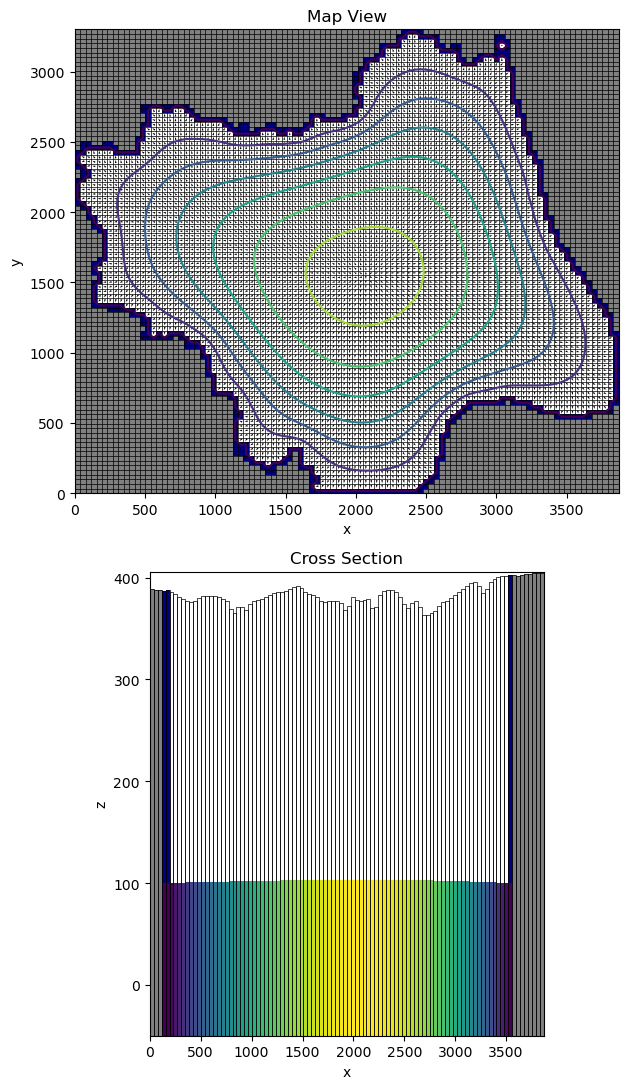

In [136]:
# create a plot of the model results
fig, axes = plt.subplots(2, 1, figsize=(8, 11))
ax = axes[0]
ax.set_title("Map View")
ax.set_aspect(1)
ax.set_xlabel("x")
ax.set_ylabel("y")
pmv = flopy.plot.PlotMapView(gwf, ax=ax)
pmv.plot_bc(ftype="CHD")
pmv.plot_inactive(color_noflow="gray")
pmv.plot_grid(color="black", linewidth=0.5)
pmv.plot_vector(qx, qy, normalize=True, color="black", istep=1, jstep=1)
pmv.contour_array(head)

ax = axes[1]
ax.set_title("Cross Section")
ax.set_aspect(10.)
ax.set_xlabel("x")
ax.set_ylabel("z")
pxs = flopy.plot.PlotCrossSection(gwf, ax=ax, line={"row": int(nrow/2)})
pxs.plot_inactive(color_noflow="gray")
pxs.plot_bc(ftype="CHD")
pxs.plot_array(head, head=head)
pxs.plot_grid(color="black", linewidth=0.5)
plt.tight_layout()